(difference_in_differences)=
# Difference in differences

:::{post} Sept, 2022
:tags: counterfactuals, causal inference, time series, regression, posterior predictive, difference in differences, quasi experiments, panel data
:category: intermediate
:author: Benjamin T. Vincent
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Introduction

This notebook provides a brief overview of the difference in differences approach to causal inference, and shows a working example of how to conduct this type of analysis under the Bayesian framework, using PyMC. While the notebooks provides a high level overview of the approach, I recommend consulting two excellent textbooks on causal inference. Both [The Effect](https://theeffectbook.net/) {cite:p}`huntington2021effect` and [Causal Inference: The Mixtape](https://mixtape.scunning.com) {cite:p}`cunningham2021causal` have chapters devoted to difference in differences.

[Difference in differences](https://en.wikipedia.org/wiki/Difference_in_differences) would be a good approach to take for causal inference if:
* you want to know the causal impact of a treatment/intervention
* you have pre and post treatment measures
* you have both a treatment and a control group
* the treatment was _not_ allocated by randomisation, that is, you are in a [quasi-experimental](https://en.wikipedia.org/wiki/Quasi-experiment) setting.

Otherwise there are likely better suited approaches you could use.

Note that our desire to estimate the causal impact of a treatment involves [counterfactual thinking](https://en.wikipedia.org/wiki/Counterfactual_thinking). This is because we are asking "What would the post-treatment outcome of the treatment group be _if_ treatment had not been administered?" but we can never observe this.

### Example

A classic example is given by a study by {cite:t}`card1993minimum`. This study examined the effects of increasing the minimum wage upon employment in the fast food sector. This is a quasi-experimental setting because the intervention (increase in minimum wages) was not applied to different geographical units (e.g. states) randomly. The intevention was applied to New Jersey in April 1992. If they measured pre and post intervention employment rates in New Jersey only, then they would have failed to control for omitted variables changing over time (e.g. seasonal effects) which could provide alternative causal explanations for changes in employment rates. But by selecting a control state (Pennsylvania), this allows one to infer that changes in employment in Pennsylvania would match the counterfactual - what _would have happened if_ New Jersey had not received the intervention?

### Causal DAG

The causal DAG for difference in differences is given below. It says:
* Treatment status of an observation is causally influenced by group and time. Note that treatment and group are different things. Group is either experimental or control, but the experimental group is only 'treated' after the intervention time, hence treatment status depends on both group and time.
* The outcome measured is causally influenced by time, group, and treatment.
* No additional causal influences are considered.

We are primarily interested in the effect of the treatment upon the outcome and how this changes over time (pre to post treatment). If we only focused on treatment, time and outcome on the treatment group (i.e. not have a control group), then we would be unable to attribute changes in the outcome to the treatment rather than any number of other factors occurring over time to the treatment group. Another way of saying this is that treatment would be fully determined by time, so there is no way to disambiguate the changes in the pre and post outcome measures as being caused by treatment or time. 

![](DAG_difference_in_differences.png)

But by adding a control group, we are able to compare the changes in time of the control group and the changes in time of the treatment group. One of the key assumptions in the difference in differences approach is the _parallel trends assumption_ - that both groups change in similar ways over time. Another way of saying this is that _if_ the control and treatment groups change in similar ways over time, then we can be fairly convinced that difference in differences in groups over time is due to the treatment.

### Define the difference in differences model

**Note:** I'm defining this model slightly differently compared to what you might find in other sources. This is to facilitate counterfactual inference later on in the notebook, and to emphasise the assumptions about trends over continuous time.

First, let's define a Python function to calculate the expected value of the outcome:

In [3]:
def outcome(t, control_intercept, treat_intercept_delta, trend, Δ, group, treated):
    return control_intercept + (treat_intercept_delta * group) + (t * trend) + (Δ * treated * group)

But we should take a closer look at this with mathematical notation. The expected value of the $i^{th}$ observation is $\mu_i$ and is defined by:

$$
\mu_i = \beta_{c} 
        + (\beta_{\Delta} \cdot \mathrm{group}_i)
        + (\mathrm{trend} \cdot t_i)
        + (\Delta \cdot \mathrm{treated}_i \cdot \mathrm{group}_i)
$$

where there are the following parameters:
* $\beta_c$ is the intercept for the control group
* $\beta_{\Delta}$ is a deflection of the treatment group intercept from the control group intercept
* $\Delta$ is the causal impact of the treatment
* $\mathrm{trend}$ is the slope, and a core assumption of the model is that the slopes are identical for both groups

and the following observed data:
* $t_i$ is time, scaled conveniently so that the pre-intervention measurement time is at $t=0$ and the post-intervention measurement time is $t=1$
* $\mathrm{group}_i$ is a dummy variable for control ($g=0$) or treatment ($g=1$) group
* $\mathrm{treated}_i$ is a binary indicator variable for untreated or treated. And this is function of both time and group: $\mathrm{treated}_i = f(t_i, \mathrm{group}_i)$.

We can underline this latter point that treatment is causally influenced by time and group by looking at the DAG above, and by writing a Python function to define this function.

In [4]:
def is_treated(t, intervention_time, group):
    return (t > intervention_time) * group

### Visualise the difference in differences model
Very often a picture is worth a thousand words, so if the description above was confusing, then I'd recommend re-reading it after getting some more visual intuition from the plot below.

In [5]:
# true parameters
control_intercept = 1
treat_intercept_delta = 0.25
trend = 1
Δ = 0.5
intervention_time = 0.5

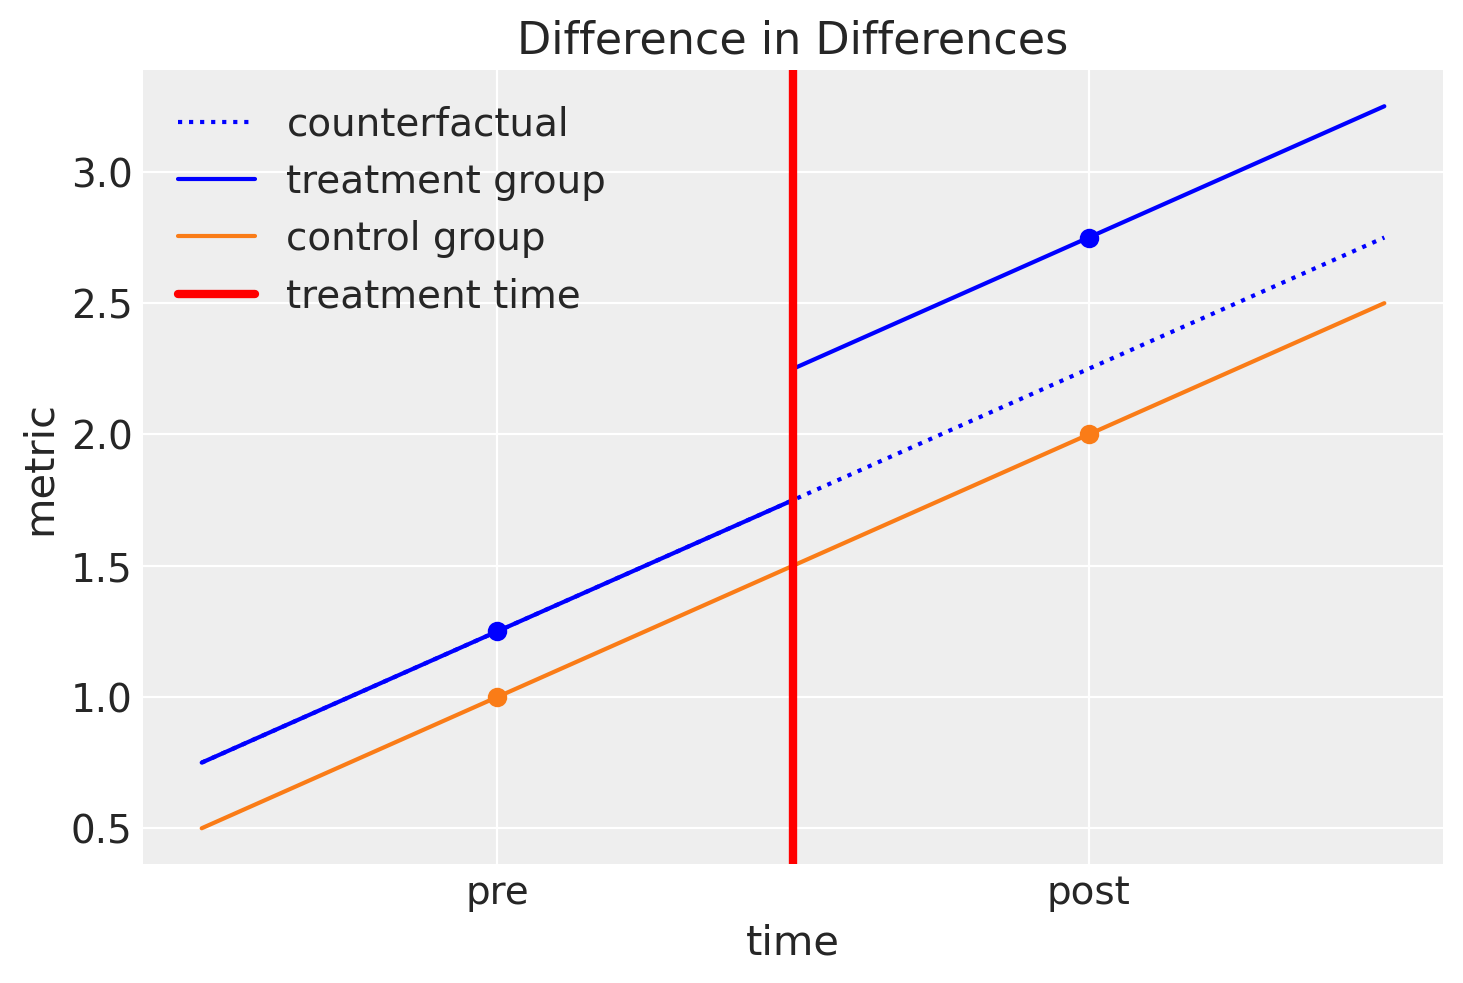

In [6]:
fig, ax = plt.subplots()
ti = np.linspace(-0.5, 1.5, 1000)
ax.plot(
    ti,
    outcome(
        ti,
        control_intercept,
        treat_intercept_delta,
        trend,
        Δ=0,
        group=1,
        treated=is_treated(ti, intervention_time, group=1),
    ),
    color="blue",
    label="counterfactual",
    ls=":",
)
ax.plot(
    ti,
    outcome(
        ti,
        control_intercept,
        treat_intercept_delta,
        trend,
        Δ,
        group=1,
        treated=is_treated(ti, intervention_time, group=1),
    ),
    color="blue",
    label="treatment group",
)
ax.plot(
    ti,
    outcome(
        ti,
        control_intercept,
        treat_intercept_delta,
        trend,
        Δ,
        group=0,
        treated=is_treated(ti, intervention_time, group=0),
    ),
    color="C1",
    label="control group",
)
ax.axvline(x=intervention_time, ls="-", color="r", label="treatment time", lw=3)
t = np.array([0, 1])
ax.plot(
    t,
    outcome(
        t,
        control_intercept,
        treat_intercept_delta,
        trend,
        Δ,
        group=1,
        treated=is_treated(t, intervention_time, group=1),
    ),
    "o",
    color="blue",
)
ax.plot(
    t,
    outcome(
        t,
        control_intercept,
        treat_intercept_delta,
        trend,
        Δ=0,
        group=0,
        treated=is_treated(t, intervention_time, group=0),
    ),
    "o",
    color="C1",
)
ax.set(
    xlabel="time",
    ylabel="metric",
    xticks=t,
    xticklabels=["pre", "post"],
    title="Difference in Differences",
)
ax.legend();

So we can summarise the intuition of difference in differences by looking at this plot:
* We assume that the treatment and control groups are evolving over time in a similar manner.
* We can easily estimate the slope of the control group from pre to post treatment.
* We can engage in counterfactual thinking and can ask: "What would the post-treatment outcome of the treatment group be _if_ they had not been treated?"

If we can answer that question and estimate this counterfactual quantity, then we can ask: "What is the causal impact of the treatment?" And we can answer this question by comparing the observed post treatment outcome of the treatment group against the counterfactual quantity.

We can think about this visually and state another way... By looking at the pre/post difference in the control group, we can attribute any differences in the pre/post differences of the control and treatment groups to the causal effect of the treatment. And that is why the method is called difference in differences.

## Generate a synthetic dataset

In [7]:
df = pd.DataFrame(
    {
        "group": [0, 0, 1, 1] * 10,
        "t": [0.0, 1.0, 0.0, 1.0] * 10,
        "unit": np.concatenate([[i] * 2 for i in range(20)]),
    }
)

df["treated"] = is_treated(df["t"], intervention_time, df["group"])

df["y"] = outcome(
    df["t"],
    control_intercept,
    treat_intercept_delta,
    trend,
    Δ,
    df["group"],
    df["treated"],
)
df["y"] += rng.normal(0, 0.1, df.shape[0])
df.head()

,group,t,unit,treated,y
0,0,0.0,0,0,0.977736
1,0,1.0,0,0,2.132566
2,1,0.0,1,0,1.192903
3,1,1.0,1,1,2.816825
4,0,0.0,2,0,1.114538


So we see that we have [panel data](https://en.wikipedia.org/wiki/Panel_data) with just two points in time: the pre ($t=0$) and post ($t=1$) intervention measurement times.

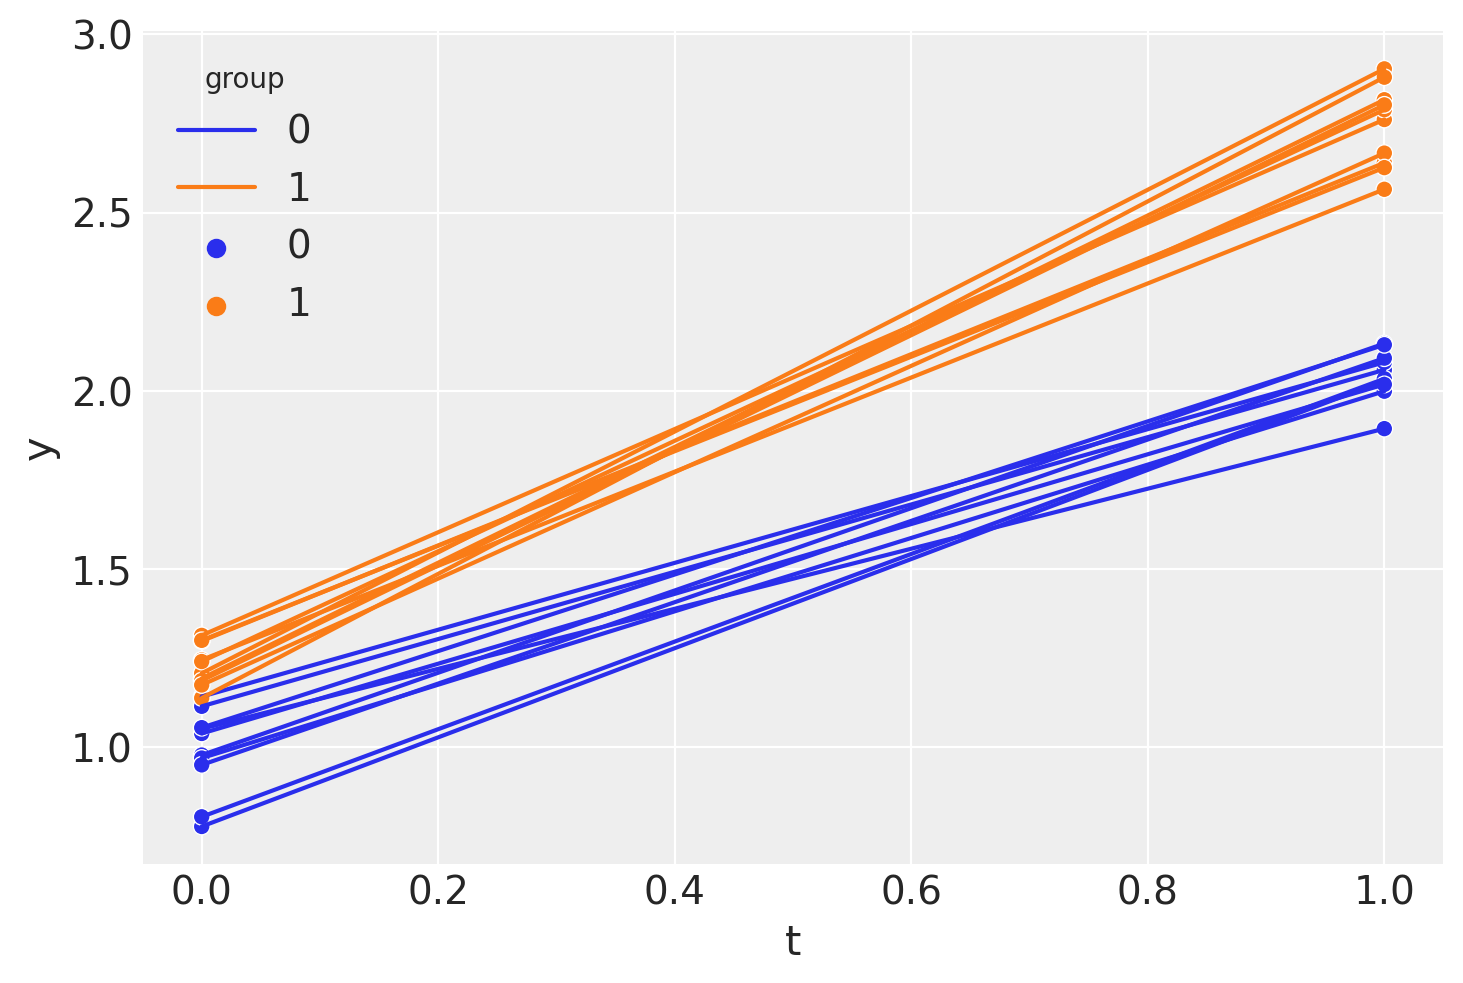

In [8]:
sns.lineplot(df, x="t", y="y", hue="group", units="unit", estimator=None)
sns.scatterplot(df, x="t", y="y", hue="group");

If we wanted, we could calculate a point estimate of the difference in differences (in a non-regression approach) like this.

In [9]:
diff_control = (
    df.loc[(df["t"] == 1) & (df["group"] == 0)]["y"].mean()
    - df.loc[(df["t"] == 0) & (df["group"] == 0)]["y"].mean()
)
print(f"Pre/post difference in control group = {diff_control:.2f}")

diff_treat = (
    df.loc[(df["t"] == 1) & (df["group"] == 1)]["y"].mean()
    - df.loc[(df["t"] == 0) & (df["group"] == 1)]["y"].mean()
)

print(f"Pre/post difference in treatment group = {diff_treat:.2f}")

diff_in_diff = diff_treat - diff_control
print(f"Difference in differences = {diff_in_diff:.2f}")

Pre/post difference in control group = 1.06
Pre/post difference in treatment group = 1.52
Difference in differences = 0.46


But hang on, we are Bayesians! Let's Bayes...

## Bayesian difference in differences

### PyMC model
For those already well-versed in PyMC, you can see that this model is pretty simple. We just have a few components:
* Define data nodes. This is optional, but useful later when we run posterior predictive checks and counterfactual inference
* Define priors
* Evaluate the model expectation using the `outcome` function that we already defined above
* Define a normal likelihood distribution.

In [10]:
with pm.Model() as model:
    # data
    t = pm.MutableData("t", df["t"].values, dims="obs_idx")
    treated = pm.MutableData("treated", df["treated"].values, dims="obs_idx")
    group = pm.MutableData("group", df["group"].values, dims="obs_idx")
    # priors
    _control_intercept = pm.Normal("control_intercept", 0, 5)
    _treat_intercept_delta = pm.Normal("treat_intercept_delta", 0, 1)
    _trend = pm.Normal("trend", 0, 5)
    _Δ = pm.Normal("Δ", 0, 1)
    sigma = pm.HalfNormal("sigma", 1)
    # expectation
    mu = pm.Deterministic(
        "mu",
        outcome(t, _control_intercept, _treat_intercept_delta, _trend, _Δ, group, treated),
        dims="obs_idx",
    )
    # likelihood
    pm.Normal("obs", mu, sigma, observed=df["y"].values, dims="obs_idx")

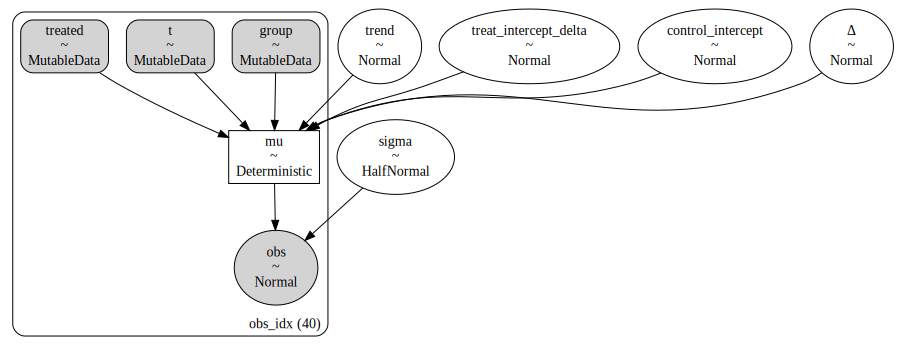

In [11]:
pm.model_to_graphviz(model)

### Inference

In [12]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [control_intercept, treat_intercept_delta, trend, Δ, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


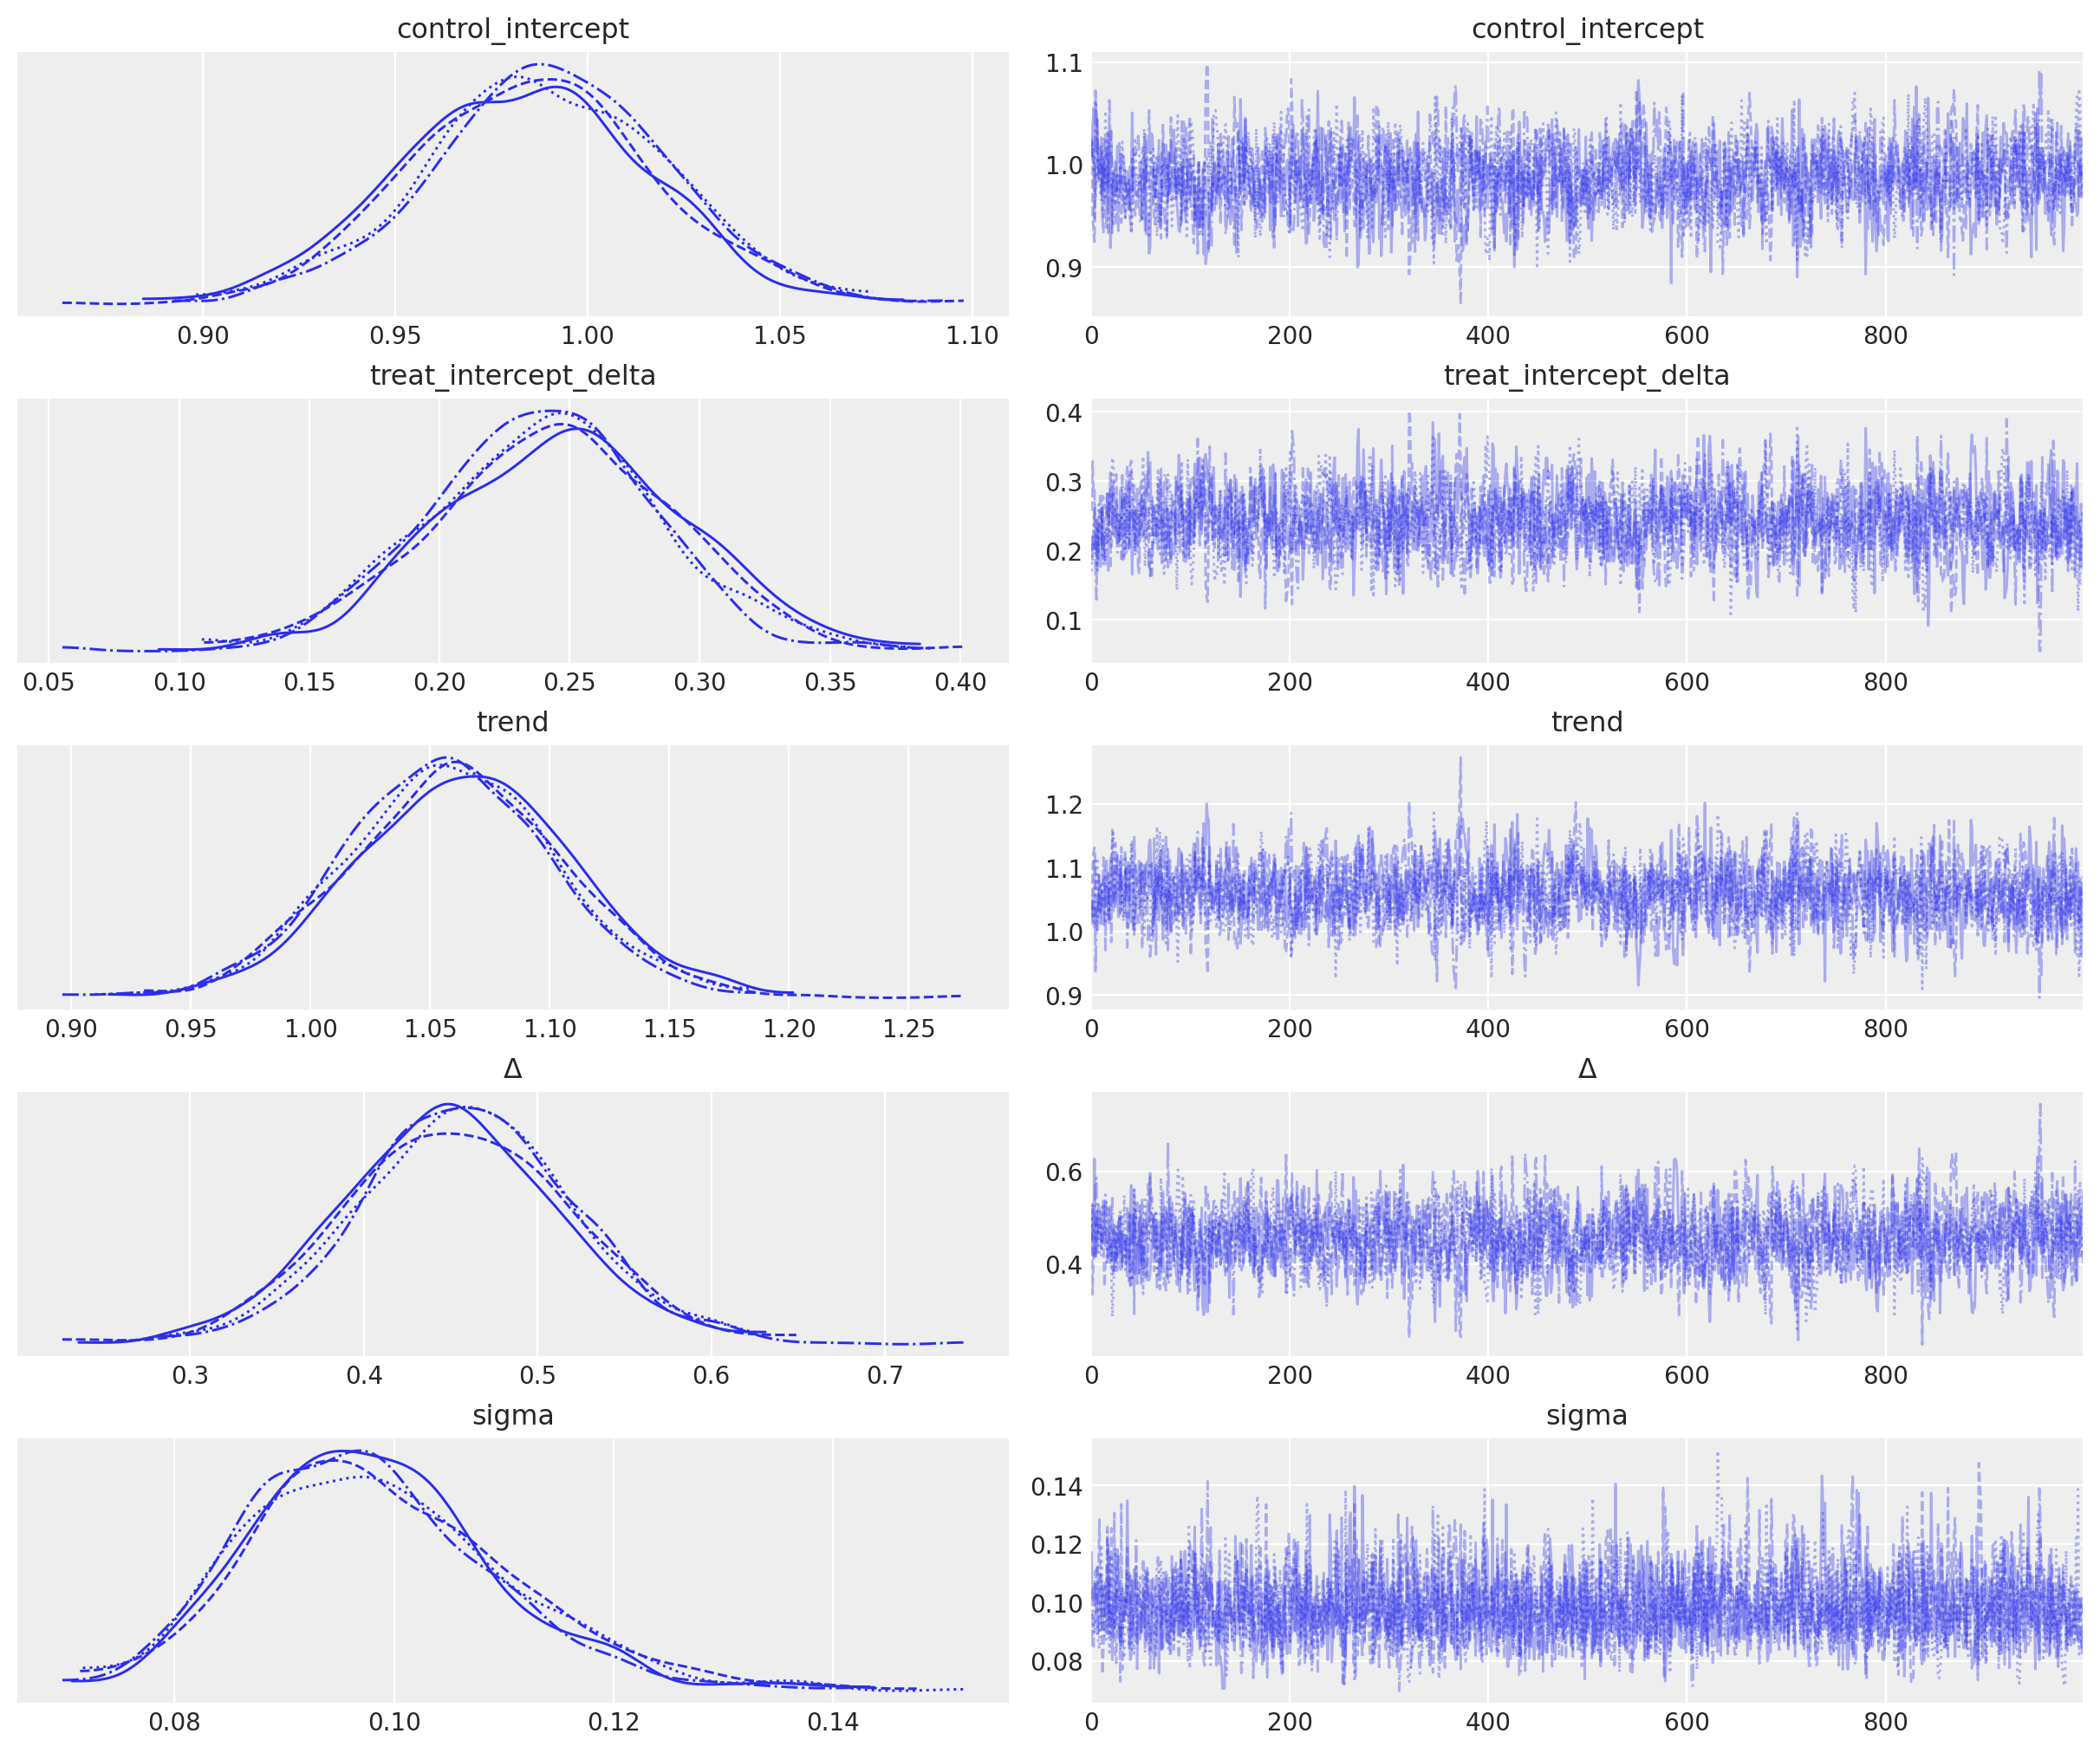

In [13]:
az.plot_trace(idata, var_names="~mu");

### Posterior prediction
NOTE: Technically we are doing 'pushforward prediction' for $\mu$ as this is a deterministic function of it's inputs. Posterior prediction would be a more appropriate label if we generated predicted observations - these would be stochastic based on the normal likelihood we've specified for our data. Nevertheless, this section is called 'posterior prediction' to emphasise the fact that we are following the Bayesian workflow.

In [14]:
# pushforward predictions for control group
with model:
    group_control = [0] * len(ti)  # must be integers
    treated = [0] * len(ti)  # must be integers
    pm.set_data({"t": ti, "group": group_control, "treated": treated})
    ppc_control = pm.sample_posterior_predictive(idata, var_names=["mu"])

# pushforward predictions for treatment group
with model:
    group = [1] * len(ti)  # must be integers
    pm.set_data(
        {
            "t": ti,
            "group": group,
            "treated": is_treated(ti, intervention_time, group),
        }
    )
    ppc_treatment = pm.sample_posterior_predictive(idata, var_names=["mu"])

# counterfactual: what do we predict of the treatment group (after the intervention) if
# they had _not_ been treated?
t_counterfactual = np.linspace(intervention_time, 1.5, 100)
with model:
    group = [1] * len(t_counterfactual)  # must be integers
    pm.set_data(
        {
            "t": t_counterfactual,
            "group": group,
            "treated": [0] * len(t_counterfactual),  # THIS IS OUR COUNTERFACTUAL
        }
    )
    ppc_counterfactual = pm.sample_posterior_predictive(idata, var_names=["mu"])

## Wrapping up
We can plot what we've learnt below:

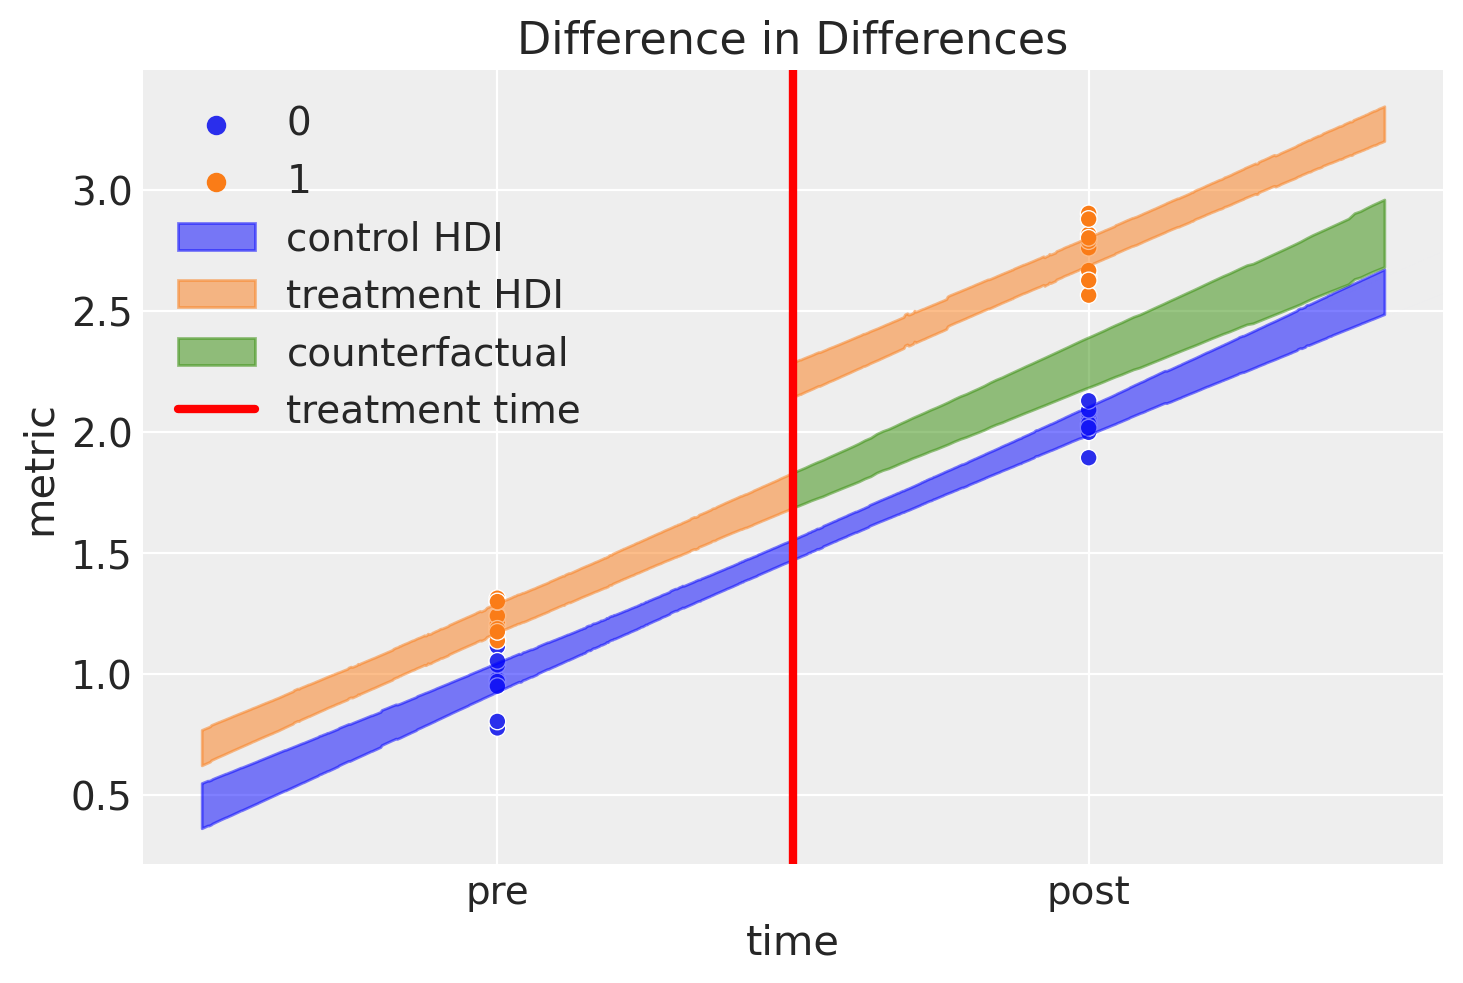

In [15]:
ax = sns.scatterplot(df, x="t", y="y", hue="group")

az.plot_hdi(
    ti,
    ppc_control.posterior_predictive["mu"],
    smooth=False,
    ax=ax,
    color="blue",
    fill_kwargs={"label": "control HDI"},
)
az.plot_hdi(
    ti,
    ppc_treatment.posterior_predictive["mu"],
    smooth=False,
    ax=ax,
    color="C1",
    fill_kwargs={"label": "treatment HDI"},
)
az.plot_hdi(
    t_counterfactual,
    ppc_counterfactual.posterior_predictive["mu"],
    smooth=False,
    ax=ax,
    color="C2",
    fill_kwargs={"label": "counterfactual"},
)
ax.axvline(x=intervention_time, ls="-", color="r", label="treatment time", lw=3)
ax.set(
    xlabel="time",
    ylabel="metric",
    xticks=[0, 1],
    xticklabels=["pre", "post"],
    title="Difference in Differences",
)
ax.legend();

This is an awesome plot, but there are quite a few things going on here, so let's go through it:
* Blue shaded region represents credible regions for the expected value of the control group
* Orange shaded region represents similar regions for the treatment group. We can see how the outcome jumps immediately after the intervention.
* The green shaded region is something pretty novel, and nice. This represents our counterfactual inference of _what we would expect if_ the treatment group were never given the treatment. By definition, we never made any observations of items in the treatment group that were not treated after the intervention time. Nevertheless, with the model described at the top of the notebook and the Bayesian inference methods outlined, we can reason about such _what if_ questions. 
* The difference between this counterfactual expectation and the observed values (post treatment in the treatment condition) represents our inferred causal impact of the treatment. Let's take a look at that posterior distribution in more detail:

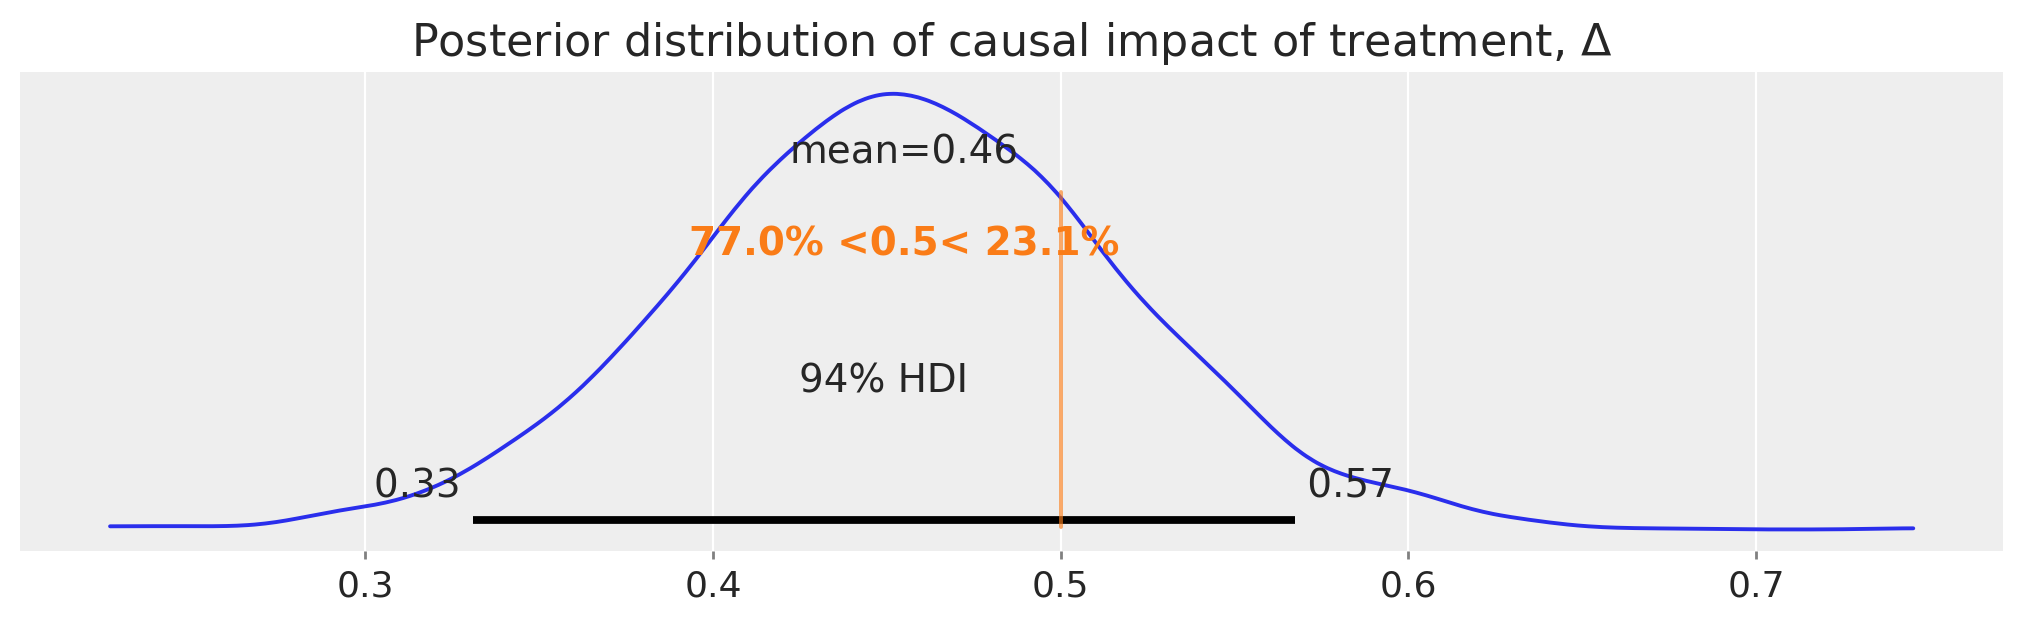

In [16]:
ax = az.plot_posterior(idata.posterior["Δ"], ref_val=Δ, figsize=(10, 3))
ax.set(title=r"Posterior distribution of causal impact of treatment, $\Delta$");

So there we have it, we have a full posterior distribution over our estimated causal impact using the difference in differences approach.

## Summary
Of course, when using the difference in differences approach for real applications, there is a lot more due diligence that's needed. Readers are encouraged to check out the textbooks listed above in the introduction as well as a useful review paper {cite:p}`wing2018designing` which covers the important contextual issues in more detail. Additionally, {cite:t}`bertrand2004much` takes a skeptical look at the approach as well as proposing solutions to some of the problems they highlight.

## References

:::{bibliography}
:filter: docname in docnames
:::

## Authors
- Authored by [Benjamin T. Vincent](https://github.com/drbenvincent) in Sept 2022 ([#424](https://github.com/pymc-devs/pymc-examples/pull/424)).

## Watermark

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Sun Sep 25 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

pytensor: 2.8.2
aeppl : 0.0.35
xarray: 2022.6.0

arviz     : 0.12.1
pymc      : 4.2.0
seaborn   : 0.12.0
matplotlib: 3.6.0
pandas    : 1.5.0
numpy     : 1.23.3

Watermark: 2.3.1



:::{include} ../page_footer.md
:::